# Imports and installations
- Pytorch
- Database import directly from Kaggle

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle}
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip '140k-real-and-fake-faces.zip';

In [ ]:
from json import load
import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,Compose, Resize, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import pandas as pd
import seaborn as sn
import timm
import matplotlib.pyplot as plt

# Auxiliary codes
- Detect GPU
- Load base
- Calculate metrics
- Evaluate model
- Get attention layer

In [ ]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]

    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
def load_data(path,train_rate,batch_size,test=False):
    NORMALIZE_MEAN = (0.5, 0.5, 0.5)
    NORMALIZE_STD = (0.5, 0.5, 0.5)
    transform = Compose([
              Resize(size=(224, 224)),
              ToTensor(),
              Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ])
    
    dataset_train = ImageFolder(path+"/train", transform=transform)
    dataset_test = ImageFolder(path+"/test", transform=transform)
    dataset_valid =ImageFolder(path+"/valid", transform=transform)


    train_dl = DataLoader(dataset_train,batch_size,shuffle=True)
    test_dl = DataLoader(dataset_test,batch_size)
    valid_dl = DataLoader(dataset_valid,batch_size)
    
    
    return train_dl,test_dl,valid_dl

def accuracy(outputs, labels):
    _,preds = torch.max(outputs,dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))
def validation_epoch_end(outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()

        return {"val_loss":epoch_loss.item(),'val_acc':epoch_acc.item()}
def epoch_end( epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):

    model.eval()
    outputs =[]

    y_pred = []
    y_true = []
    for batch in val_loader:

        out = model(batch[0])
        y_pred.extend(torch.max(out,dim = 1)[1].data.cpu().numpy())

        labels = batch[1].data.cpu().numpy()
        y_true.extend(labels)

        loss = F.cross_entropy(out,batch[1])
        acc = accuracy(out,batch[1])
        outputs.append({'val_loss': loss.detach(), "val_acc":acc})
        #break
    return validation_epoch_end(outputs), y_true,y_pred

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
def get_attention_matrix(model, img_path,sequential=False,patch = 8):
  device = get_default_device()
  model.to(device)
  #"/content/real_vs_fake/real-vs-fake/test/fake/06TAEXDQGR.jpg"
  if sequential:
    model[0].blocks[-1].attn.qkv.register_forward_hook(get_activation('qkv'))
  else:
    model.blocks[-1].attn.qkv.register_forward_hook(get_activation('qkv'))
  img = Image.open(img_path)
  transform = Compose([Resize(size=(224, 224)), ToTensor()])
  x = transform(img)
  x.size()
  x = x.cuda()
  logits = model(x.unsqueeze(0))
  att_mat = activation['qkv']
  print(activation['qkv'].size())
  input_expanded = activation['qkv'][0]
  print(input_expanded.shape)
  if patch ==8:
    qkv = input_expanded.reshape(785, 3, 12, 768//12)
  else:
    qkv = input_expanded.reshape(197, 3, 12, 768//12)
  print("split qkv : ", qkv.shape)
  q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
  k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
  kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
  print("transposed ks: ", kT.shape)
  attention_matrix = q @ kT
  return attention_matrix, img
  


In [ ]:
def show_figure(att_matrix_1, att_matrix_2, img, patch = 8,att_matrix_3 = None,qtd_models = 2):
    if patch ==8:
      fig_size = (28,28)
    else:
      fig_size= (14,14)
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle("Visualização da Camada de Atenção - ViT e Dino 8Pacthes", fontsize=24)
    fig.add_axes()
    img = np.asarray(img)
    if qtd_models == 3:
      lines = 3
    else:
      lines = 2
    ax = fig.add_subplot(lines, 3, 1)
    ax.imshow(img)
    ax = fig.add_subplot(lines, 3, 1)
    attn_heatmap = att_matrix_1[6, -1, 1:].reshape(fig_size).detach().cpu().numpy()
    ax = fig.add_subplot(lines, 3, 2)
    ax.imshow(attn_heatmap)

    attn_heatmap = att_matrix_1[8, -1, 1:].reshape(fig_size).detach().cpu().numpy()
    ax = fig.add_subplot(lines, 3, 3)
    ax.imshow(attn_heatmap)

    ax = fig.add_subplot(lines, 3, 4)
    ax.imshow(img)

    attn_heatmap = att_matrix_2[6, -1, 1:].reshape(fig_size).detach().cpu().numpy()
    ax = fig.add_subplot(lines, 3, 5)
    ax.imshow(attn_heatmap)

    attn_heatmap = att_matrix_2[8, -1, 1:].reshape(fig_size).detach().cpu().numpy()
    ax = fig.add_subplot(lines, 3, 6)
    ax.imshow(attn_heatmap)

    if qtd_models ==3:
      ax = fig.add_subplot(lines, 3, 7)
      ax.imshow(img)

      attn_heatmap = att_matrix_3[6, -1, 1:].reshape(fig_size).detach().cpu().numpy()
      ax = fig.add_subplot(lines, 3, 8)
      ax.imshow(attn_heatmap)

      attn_heatmap = att_matrix_3[8, -1, 1:].reshape(fig_size).detach().cpu().numpy()
      ax = fig.add_subplot(lines, 3, 9)
      ax.imshow(attn_heatmap)

# Joint analysis of the models
- DINO e ViT(Original) 8x8
- DINO, ViT(Original) e DeiT 16x16

In [ ]:

dino8_path = '/content/drive/MyDrive/plano_b/vit_base_patch8_dino_224.pt'
dino8= torch.hub.load('facebookresearch/dino:main', 'dino_vitb8', pretrained=True)

mlp = nn.Linear(768,2)
dino8 = nn.Sequential(dino8,mlp)
dino8.load_state_dict(torch.load(dino8_path))

vit8 = torch.load('/content/drive/MyDrive/plano_b/vit_base_patch8_224.pth')



Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

In [ ]:

dino16_path = '/content/drive/MyDrive/plano_b/vit_base_patch16_dino_224.pt'
dino16= torch.hub.load('facebookresearch/dino:main', 'dino_vitb16', pretrained=True)

mlp = nn.Linear(768,2)
dino16 = nn.Sequential(dino16,mlp)
dino16.load_state_dict(torch.load(dino16_path))

vit16 = torch.load('/content/drive/MyDrive/plano_b/vit_base_patch16_224.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


In [ ]:
deit16_path = '/content/drive/MyDrive/plano_b/deit_base_patch16_224.pt'
deit16= torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
deit16.head = nn.Linear(768,2)
deit16.load_state_dict(torch.load(deit16_path))

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


<All keys matched successfully>

# Getting the attention matrices of fake ViT and Dino 8X8 images

## Exemple 1

torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])
torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])


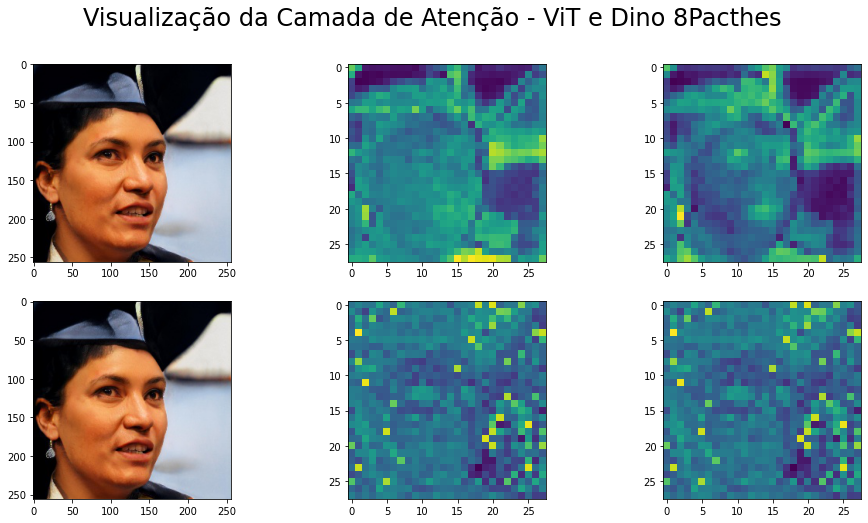

In [ ]:
dino8_att_matrix_false, img = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0V9Z5KYGX1.jpg',sequential=True)
vit8_att_matrix_false,_ = get_attention_matrix(vit8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0V9Z5KYGX1.jpg')
show_figure(dino8_att_matrix_false,vit8_att_matrix_false,img)

## Exemple 2

torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])
torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])


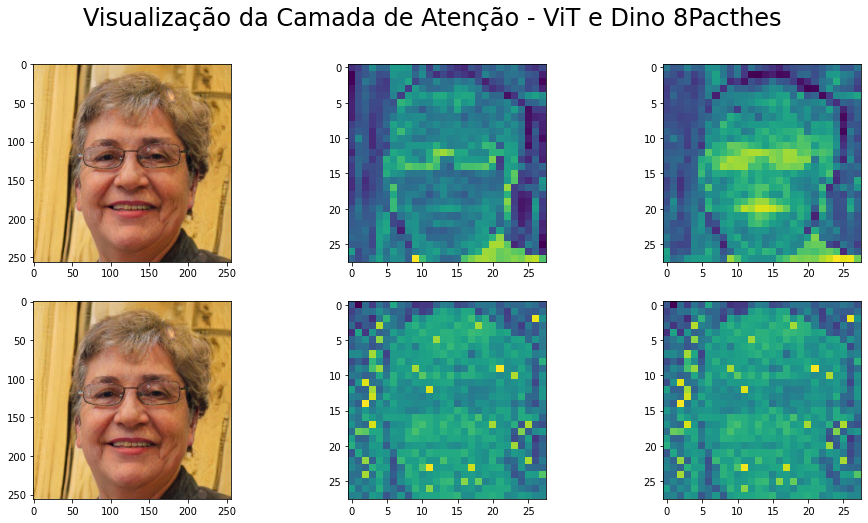

In [ ]:
dino8_att_matrix_false, img = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0QRC2OPACM.jpg',sequential=True)
vit8_att_matrix_false,_ = get_attention_matrix(vit8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0QRC2OPACM.jpg')
show_figure(dino8_att_matrix_false,vit8_att_matrix_false,img)

## Exemple 3

torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])
torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])


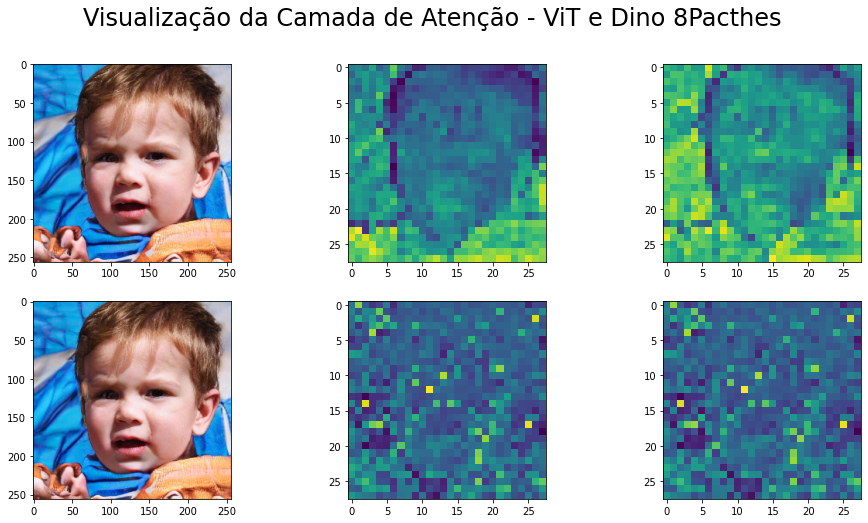

In [ ]:
dino8_att_matrix_false, img = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0LIB90T8PL.jpg',sequential=True)
vit8_att_matrix_false,_ = get_attention_matrix(vit8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0LIB90T8PL.jpg')
show_figure(dino8_att_matrix_false,vit8_att_matrix_false,img)

## Exemple 4

torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])
torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])


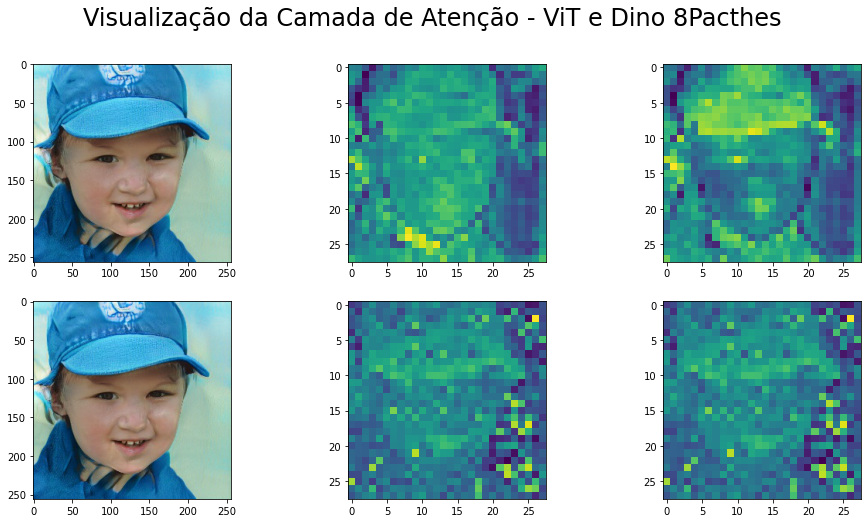

In [ ]:
dino8_att_matrix_false, img = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/10XVDD87EJ.jpg',sequential=True)
vit8_att_matrix_false,_ = get_attention_matrix(vit8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/10XVDD87EJ.jpg')
show_figure(dino8_att_matrix_false,vit8_att_matrix_false,img)

# Getting the attention matrices of fake ViT and Dino and DeiT 16X16 images

## Exemple 1

torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


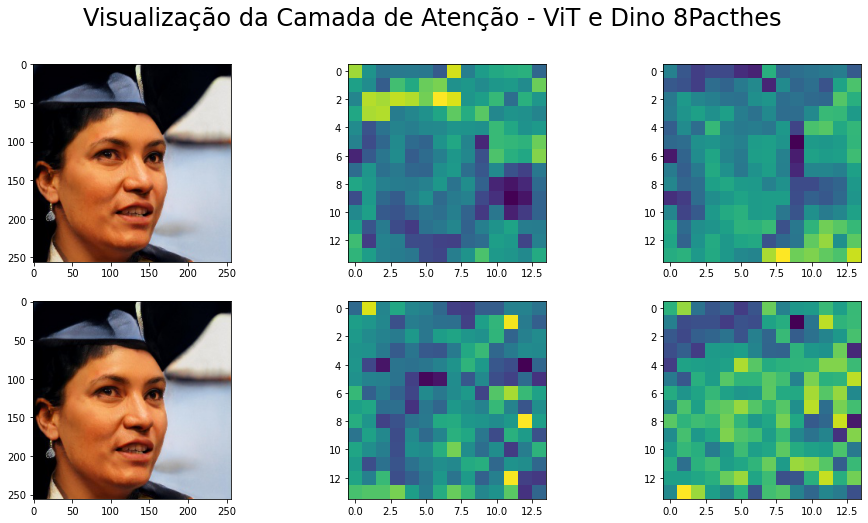

In [ ]:
dino16_att_matrix_false, img = get_attention_matrix(dino16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0V9Z5KYGX1.jpg',sequential=True,patch=16)
vit16_att_matrix_false,_ = get_attention_matrix(vit16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0V9Z5KYGX1.jpg',patch =16)
#deit16_att_matrix, _ = get_attention_matrix(deit16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0V9Z5KYGX1.jpg',patch =16)
show_figure(dino16_att_matrix_false,vit16_att_matrix_false, img =img,patch=16)


## Exemple 2

torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


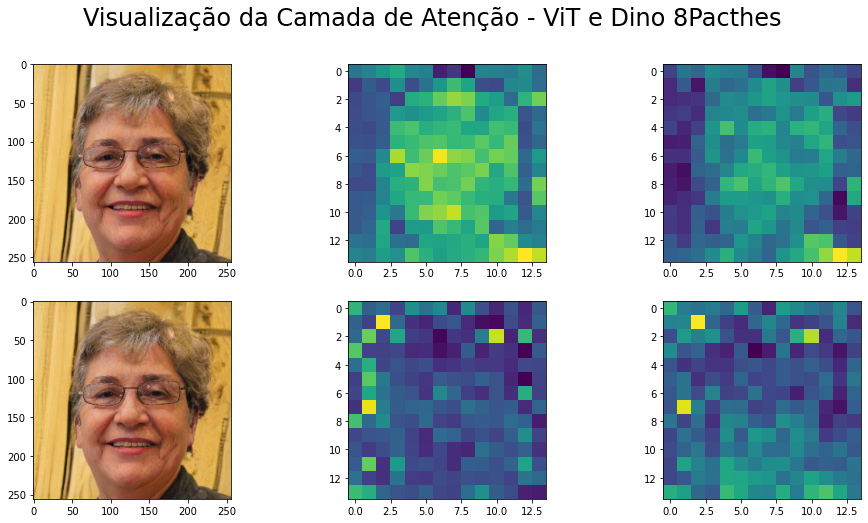

In [ ]:
dino16_att_matrix_false, img = get_attention_matrix(dino16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0QRC2OPACM.jpg',sequential=True,patch=16)
vit16_att_matrix_false,_ = get_attention_matrix(vit16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0QRC2OPACM.jpg',patch=16)
show_figure(dino16_att_matrix_false,vit16_att_matrix_false,img,patch=16)


## Exemple 3

torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


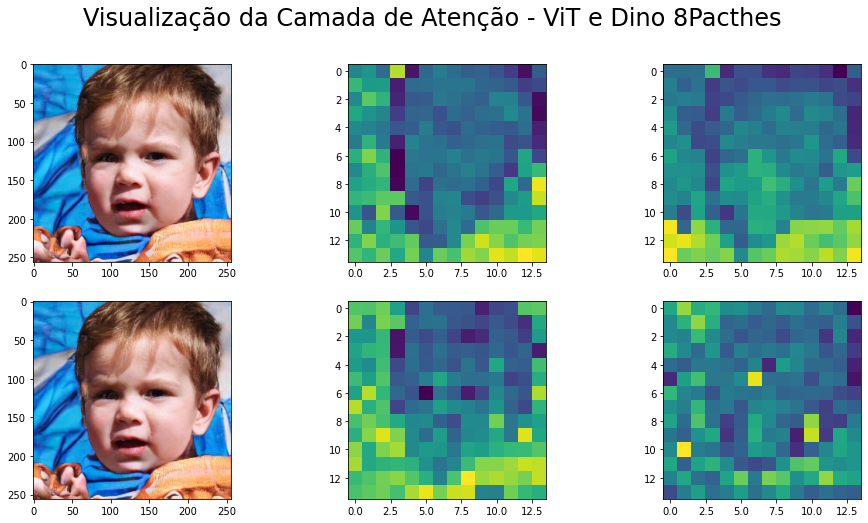

In [ ]:
dino16_att_matrix_false, img = get_attention_matrix(dino16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0LIB90T8PL.jpg',sequential=True,patch=16)
vit16_att_matrix_false,_ = get_attention_matrix(vit16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/0LIB90T8PL.jpg',patch=16)
show_figure(dino16_att_matrix_false,vit16_att_matrix_false,img,patch=16)


## Exemple 4

torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


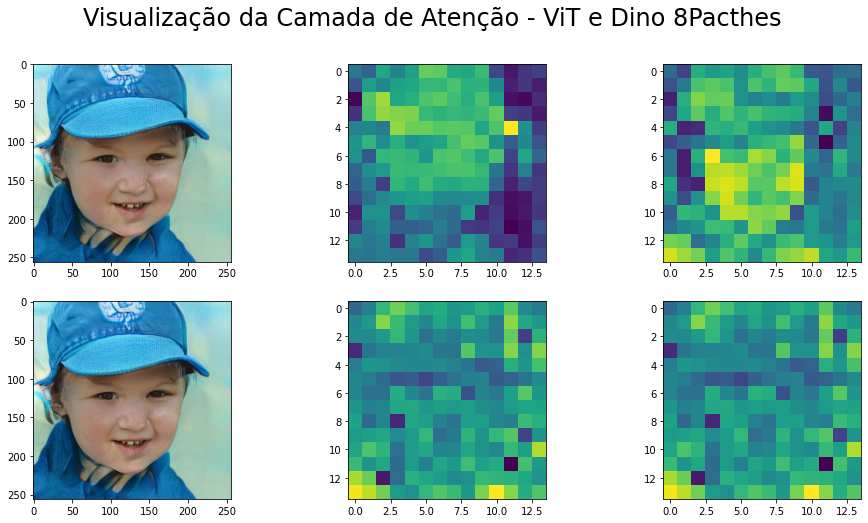

In [ ]:
dino16_att_matrix_false, img = get_attention_matrix(dino16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/10XVDD87EJ.jpg',sequential=True,patch=16)
vit16_att_matrix_false,_ = get_attention_matrix(vit16,img_path='/content/real_vs_fake/real-vs-fake/test/fake/10XVDD87EJ.jpg',patch=16)
show_figure(dino16_att_matrix_false,vit16_att_matrix_false,img,patch=16)
#dino8_att_matrix_true = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/06TAEXDQGR.jpg',sequential=True)
#vit8_att_matrix_true = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/fake/06TAEXDQGR.jpg')

# Getting the attention matrices from real ViT and Dino 8X8 images

## Exemple 1

In [ ]:
dino8_att_matrix_false, img = get_attention_matrix(dino8,img_path='/content/real_vs_fake/real-vs-fake/test/real/00265.jpg',sequential=True)
vit8_att_matrix_false,_ = get_attention_matrix(vit8,img_path='/content/real_vs_fake/real-vs-fake/test/real/00265.jpg')


torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])
torch.Size([1, 785, 2304])
torch.Size([785, 2304])
split qkv :  torch.Size([785, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 785])


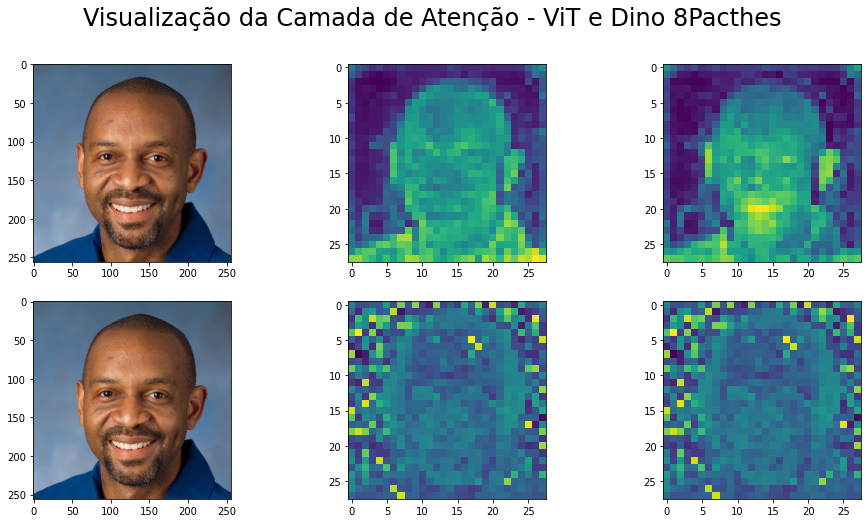

In [ ]:
show_figure(dino8_att_matrix_false,vit8_att_matrix_false,img)

# Getting the attention matrices of real ViT and Dino 16x16 images

## Exemple 1

In [ ]:
dino16_att_matrix_false, img = get_attention_matrix(dino16,img_path='/content/real_vs_fake/real-vs-fake/test/real/00265.jpg',sequential=True,patch = 16)
vit16_att_matrix_false,_ = get_attention_matrix(vit16,img_path='/content/real_vs_fake/real-vs-fake/test/real/00265.jpg',patch=16)


torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
torch.Size([1, 197, 2304])
torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


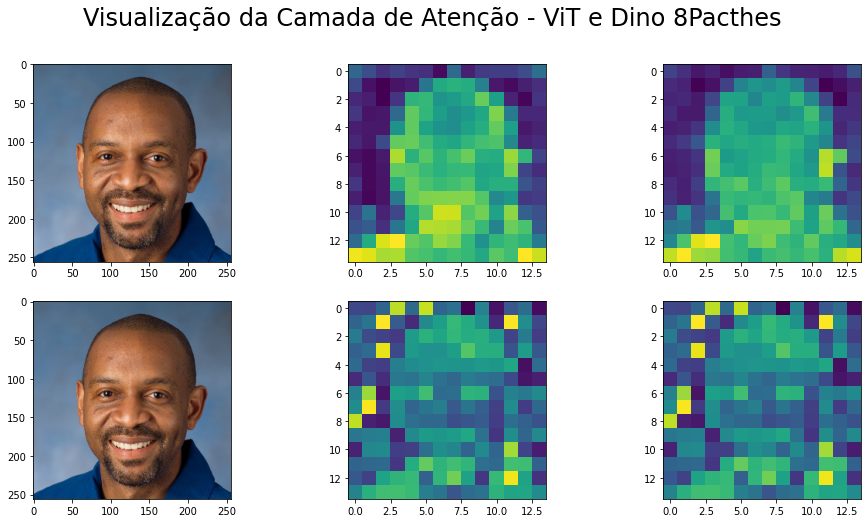

In [ ]:
show_figure(dino16_att_matrix_false,vit16_att_matrix_false,img,patch=16)

# Analyzing the sample classification for all models

In [ ]:
train,test,valid = load_data('/content/real_vs_fake/real-vs-fake',0.8,64)
device = get_default_device()

test = DeviceDataLoader(test,device)


In [ ]:
vgg16 = timm.create_model('vgg16', pretrained=True,num_classes=2)
vgg16.load_state_dict(torch.load("/content/drive/MyDrive/plano_b/vgg16_224.pt"))
vgg16.to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:

metrics_dino,y_true_dino,y_pred_dino = evaluate(dino8,test)
print("Acuária Dino")
epoch_end(1,metrics_dino)
torch.cuda.empty_cache()
print("Acuária Vit")
metrics_vit,y_true_vit,y_pred_vit = evaluate(vit8,test)
epoch_end(1,metrics_vit)
torch.cuda.empty_cache()
print("Acurácia VGG16")
vgg16.to(device)
metrics_vgg16,y_true_vgg16,y_pred_vgg16 = evaluate(vgg16,test)
epoch_end(1,metrics_vgg16) 

Acuária Dino
Epoch [1], val_loss: 0.0640, val_acc: 0.9766
Acuária Vit
Epoch [1], val_loss: 0.0539, val_acc: 0.9805
Acurácia VGG16
Epoch [1], val_loss: 0.0383, val_acc: 0.9850


In [ ]:
pred_dict = {"dino8":y_pred_dino,"vit8":y_pred_vit,"vgg16":y_pred_vgg16,"y_true":y_true_dino}
pred_total = pd.DataFrame(pred_dict)
pred_total

,dino8,vit8,vgg16,y_true
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
19995,1,1,1,1
19996,1,1,1,1
19997,1,1,1,1
19998,1,1,1,1


In [ ]:
indices_vgg_erro = pred_total[(pred_total['vgg16']!=pred_total['y_true'])&
                              (pred_total['vit8']==pred_total['y_true'])&
                              (pred_total['dino8']==pred_total['y_true'])]
indices_vgg_erro                            

,dino8,vit8,vgg16,y_true
5,0,0,1,0
7,0,0,1,0
113,0,0,1,0
131,0,0,1,0
133,0,0,1,0
...,...,...,...,...
19504,1,1,0,1
19525,1,1,0,1
19825,1,1,0,1
19846,1,1,0,1


In [ ]:
indices_vgg_acertos = pred_total[(pred_total['vgg16']==pred_total['y_true'])&
                              (pred_total['vit8']!=pred_total['y_true'])&
                              (pred_total['dino8']!=pred_total['y_true'])]
indices_vgg_acertos                              

,dino8,vit8,vgg16,y_true
737,1,1,0,0
2663,1,1,0,0
2887,1,1,0,0
3605,1,1,0,0
4880,1,1,0,0
6199,1,1,0,0
6744,1,1,0,0
7109,1,1,0,0
7395,1,1,0,0
7600,1,1,0,0


In [ ]:
indices_dino_acertos = pred_total[(pred_total['vit8']!=pred_total['y_true'])&
                              (pred_total['dino8']==pred_total['y_true'])]
indices_dino_acertos     

,dino8,vit8,vgg16,y_true
33,0,1,0,0
42,0,1,0,0
80,0,1,0,0
96,0,1,0,0
139,0,1,0,0
...,...,...,...,...
19213,1,0,1,1
19431,1,0,1,1
19588,1,0,1,1
19758,1,0,1,1


In [ ]:
indices_vit_acertos = pred_total[(pred_total['vit8']==pred_total['y_true'])&
                              (pred_total['dino8']!=pred_total['y_true'])]
indices_vit_acertos     

,dino8,vit8,vgg16,y_true
49,1,0,0,0
61,1,0,0,0
449,1,0,0,0
536,1,0,0,0
584,1,0,1,0
...,...,...,...,...
19798,0,1,1,1
19824,0,1,1,1
19946,0,1,1,1
19951,0,1,1,1


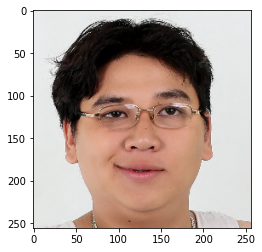

In [ ]:
from torchvision.utils import save_image
test_folder = ImageFolder("/content/real_vs_fake/real-vs-fake/test",transform=ToTensor())
test_images = DataLoader(test_folder)
indices_vit_acertos_indexes = indices_vit_acertos.index.to_list()
print(test_images)
i = 0
j=0
for batch in test_images:
  if i in indices_vit_acertos_indexes:
    plt.imshow(batch[0][0].permute(1,2,0))
    save_image(batch[0][0],'/content/drive/MyDrive/plano_b/Imagens/vit_correct/'+str(i)+"-"+str(batch[1].data.cpu().numpy())+"vit_correct.png")
  i+=1
  


  

[49, 61, 449, 536, 584, 632, 645, 695, 741, 800, 911, 923, 934, 1017, 1055, 1072, 1115, 1179, 1186, 1193, 1291, 1376, 1413, 1426, 1442, 1454, 1480, 1529, 1532, 1623, 1726, 1781, 1826, 1926, 1941, 1947, 1960, 2003, 2042, 2055, 2074, 2245, 2281, 2294, 2397, 2522, 2541, 2639, 2722, 2903, 2935, 2946, 3007, 3094, 3113, 3156, 3209, 3219, 3227, 3316, 3325, 3452, 3478, 3489, 3497, 3648, 3672, 3728, 3840, 3889, 3923, 3930, 3965, 4016, 4050, 4105, 4146, 4199, 4235, 4310, 4340, 4345, 4533, 4541, 4620, 4637, 4688, 4692, 4732, 4876, 4953, 4962, 5068, 5142, 5204, 5248, 5361, 5369, 5377, 5448, 5530, 5546, 5568, 5606, 5688, 5729, 5783, 5796, 5833, 5900, 5943, 5953, 5965, 6034, 6106, 6137, 6173, 6204, 6231, 6256, 6305, 6393, 6417, 6436, 6485, 6493, 6509, 6534, 6567, 6649, 6697, 6721, 6927, 6994, 7207, 7243, 7275, 7279, 7319, 7329, 7386, 7469, 7470, 7506, 7651, 7704, 7720, 7724, 7749, 7807, 7828, 7883, 7896, 7931, 7933, 8052, 8067, 8100, 8194, 8218, 8303, 8338, 8446, 8450, 8556, 8718, 8740, 8848, 8865, 

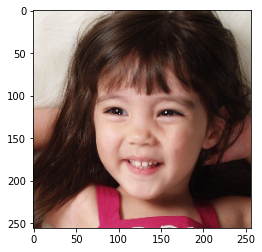

In [ ]:
indices_dino_acertos_indexes = indices_dino_acertos.index.to_list()
print(indices_vit_acertos_indexes)
i = 0
j=0
for batch in test_images:
  if i in indices_dino_acertos_indexes:
    plt.imshow(batch[0][0].permute(1,2,0))
    save_image(batch[0][0],'/content/drive/MyDrive/plano_b/Imagens/dino_correct/'+str(i)+"-"+str(batch[1].data.cpu().numpy())+"vit_correct.png")
  i+=1

[5, 7, 113, 131, 133, 196, 229, 397, 516, 543, 609, 651, 684, 812, 822, 895, 907, 1073, 1129, 1306, 1382, 1564, 1635, 1683, 1695, 1763, 1848, 1851, 1884, 1885, 1888, 1989, 2026, 2090, 2160, 2340, 2412, 2472, 2530, 2558, 2716, 2721, 2800, 2944, 2963, 3134, 3173, 3181, 3257, 3269, 3400, 3458, 3465, 3472, 3637, 3768, 3797, 3812, 3834, 3945, 3950, 3997, 4095, 4126, 4275, 4304, 4307, 4330, 4335, 4510, 4560, 4628, 4631, 4652, 4670, 4671, 4736, 4769, 4775, 4821, 4834, 4865, 4872, 4885, 4913, 4931, 4966, 4992, 5013, 5025, 5031, 5121, 5141, 5164, 5344, 5519, 5521, 5535, 5569, 5744, 5780, 5793, 5819, 5866, 5895, 5955, 5956, 6039, 6041, 6124, 6149, 6188, 6308, 6323, 6414, 6441, 6456, 6532, 6556, 6598, 6713, 6787, 6811, 6871, 6940, 6959, 7042, 7069, 7120, 7201, 7264, 7287, 7334, 7420, 7467, 7535, 7563, 7690, 7707, 7730, 7740, 7873, 7878, 7966, 7983, 8036, 8097, 8146, 8296, 8347, 8427, 8505, 8539, 8596, 8605, 8686, 8708, 8773, 8846, 8984, 9006, 9008, 9092, 9110, 9166, 9173, 9235, 9278, 9314, 9384, 

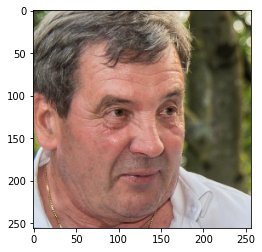

In [ ]:
indices_vgg_erro_indexes = indices_vgg_erro.index.to_list()
print(indices_vgg_erro_indexes)
i = 0
j=0
for batch in test_images:
  if i in indices_vgg_erro_indexes:
    plt.imshow(batch[0][0].permute(1,2,0))
    save_image(batch[0][0],'/content/drive/MyDrive/plano_b/Imagens/vgg_incorrect/'+str(i)+"-"+str(batch[1].data.cpu().numpy())+"vgg_incorrect.png")
  i+=1

[737, 2663, 2887, 3605, 4880, 6199, 6744, 7109, 7395, 7600, 8674, 9748, 10134, 10174, 10581, 10965, 11136, 11388, 11444, 11453, 11667, 11986, 12114, 12337, 12388, 13271, 13588, 13594, 14107, 14141, 14901, 14971, 15011, 15308, 16384, 16577, 16593, 18523, 18592, 18649, 18718, 19272]


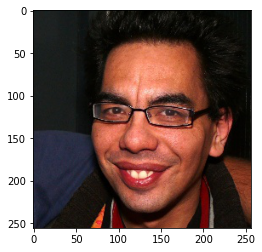

In [ ]:
indices_vgg_acertos_indexes = indices_vgg_acertos.index.to_list()
print(indices_vgg_acertos_indexes)
i = 0
j=0
for batch in test_images:
  if i in indices_vgg_acertos_indexes:
    plt.imshow(batch[0][0].permute(1,2,0))
    save_image(batch[0][0],'/content/drive/MyDrive/plano_b/Imagens/vgg_correct/'+str(i)+"-"+str(batch[1].data.cpu().numpy())+"vgg_correct.png")
  i+=1